In [31]:
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from loguru import logger
from matplotlib import pyplot as plt
from source.utils.file_read import process_and_concat_files 
from source.utils.file_read import filter_df
from source.utils.generate_timestamp import generate_timestamps
from source.forecasters.deterministic import create_day_ahead_predictions, create_day_ahead_11_predictions, create_week_ahead_predictions
from source.forecasters.probabilistic import create_day_ahead_quantiles10, create_day_ahead_11_quantiles10, create_week_ahead_quantiles10
from source.forecasters.probabilistic import create_day_ahead_quantiles90, create_day_ahead_11_quantiles90, create_week_ahead_quantiles90
from source.utils.data_preprocess import normalize_dataframe
from source.ensemble.stack_generalization.feature_engineering.data_augmentation import create_augmented_dataframe
from source.ensemble.stack_generalization.data_preparation.data_train_test import prepare_train_test_data, get_numpy_Xy_train_test
from source.ensemble.stack_generalization.ensemble_model import run_ensemble_predictions_per_quantile, run_ensemble_variability_predictions
from source.ensemble.stack_generalization.second_stage.create_data_second_stage import create_2stage_dataframe, create_augmented_dataframe_2stage, create_var_ensemble_dataframe
from source.ensemble.stack_generalization.utils.results import collect_quantile_ensemble_predictions, create_ensemble_dataframe
from source.ensemble.stack_generalization.utils.display_results import display_forecasting_metrics
from source.ensemble.combination_scheme.equal_weights import calculate_equal_weights
from source.ensemble.combination_scheme.avg_weights import calculate_weighted_avg
from source.ensemble.utils.metrics import calculate_rmse, calculate_pinball_losses
from source.plots.plot_forecasts import plot_ensemble_forecasts, plot_var_ensemble_forecasts, plot_ramp_events, plot_weighted_avg_forecasts, plot_baseline_forecasts
from source.ensemble.stack_generalization.test_importance.first_stage_importance import first_stage_permutation_importance
from source.ensemble.stack_generalization.test_importance.second_stage_importance import second_stage_permutation_importance
from source.ensemble.stack_generalization.test_importance.plot_permutation_importance import plot_normalized_contributions
from source.ensemble.combination_scheme.weight_avg_plot_importance import plot_weight_avg_contributions
from sklearn.utils.fixes import parse_version, sp_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [32]:
from config.PREDICO_setting import Simulation, WeightedAvg, Stack

sim_params = Simulation.testing_period
weight_avg_params = WeightedAvg.params
ens_params = Stack.params

# Read Files

In [33]:
# set random seed
np.random.seed(42)

files = [sim_params['file_0'], sim_params['file_1'], sim_params['file_2'], sim_params['file_3'], sim_params['file_4']]
df = process_and_concat_files(files)

# get the maximum capacity
maximum_capacity = df.measured.max()

df_filtered = filter_df(df, sim_params['forecasts_col'], sim_params['measured_col'])

# Forecasters

In [34]:
# loss quantile gradient boosting regressor
lst_rmse_gbr_ensemble = []
# loss equal weights scheme
lst_rmse_equal_weights = []
# loss weighted average scheme
lst_rmse_weighted_avg = []
# loss baseline day ahead
lst_rmse_baseline_dayahead = []
# loss baseline day ahead 11
lst_rmse_baseline_dayahead11h = []
# loss baseline week ahead
lst_rmse_baseline_week_ahead = []

# loss var gradient boosting regressor
lst_rmse_var_gbr_ensemble = []
# loss var equal weights scheme
lst_rmse_var_equal_weights = []
# loss var weighted average scheme
lst_rmse_var_weighted_avg = []
# loss var baseline day ahead
lst_rmse_var_baseline_dayahead = []
# loss var baseline day ahead 11
lst_rmse_var_baseline_dayahead11h = []
# loss var baseline week ahead
lst_rmse_var_baseline_week_ahead = []

# loss quantile gradient boosting regressor
lst_pb_gbr_ensemble_q10 = []
lst_pb_gbr_ensemble_q90 = []
# loss equal weights scheme
lst_pb_weighted_avg_q10 = []
lst_pb_weighted_avg_q90 = []
# loss weighted average scheme
lst_pb_equal_weights_q10 = []
lst_pb_equal_weights_q90 = []
# loss baseline day ahead
lst_pb_dayahead_q10 = []
lst_pb_dayahead_q90  = []
# loss baseline day ahead 11
lst_pb_dayahead_11h_q10 = []
lst_pb_dayahead_11h_q90 = []
# loss baseline week ahead
lst_pb_week_ahead_q10 = []
lst_pb_week_ahead_q90 = []


i = 0

# generate timestamps train and prediction
start_training_timestamp, end_training_timestamp, start_prediction_timestamp, end_prediction_timestamp = generate_timestamps(sim_params['start_training'], i, sim_params['window_size'])

logger.info(' ')
logger.opt(colors = True).info('<blue>-------------------------------------------------------------------------------------------</blue>')
logger.opt(colors = True).info(f'<blue>Start prediction: {start_prediction_timestamp} - End prediction: {end_prediction_timestamp}</blue>')

df_train = df_filtered[df_filtered.index.to_series().between(start_training_timestamp, end_training_timestamp)].iloc[:-1,:]
df_test = df_filtered[df_filtered.index.to_series().between(start_prediction_timestamp, end_prediction_timestamp)].iloc[:-1,:]

logger.info(' ')
logger.opt(colors = True).info('<blue> -----------------> Forecasters prediction submitted </blue>')

# forecaster - day ahead forecast
df_day_ahead_pred_train = create_day_ahead_predictions(df_train)
df_day_ahead_pred_test = create_day_ahead_predictions(df_test)

# forecaster - day ahead 11 forecast
df_day_ahead11_pred_train = create_day_ahead_11_predictions(df_train)
df_day_ahead11_pred_test = create_day_ahead_11_predictions(df_test)

# forecaster - week ahead forecast
df_week_ahead_pred_train = create_week_ahead_predictions(df_train)
df_week_ahead_pred_test = create_week_ahead_predictions(df_test)

# forecaster - day ahead quantile-10
df_day_ahead_q10_train = create_day_ahead_quantiles10(df_train)
df_day_ahead_q10_test = create_day_ahead_quantiles10(df_test)

# forecaster - day ahead 11 quantile-10
df_day_ahead11_q10_train = create_day_ahead_11_quantiles10(df_train)
df_day_ahead11_q10_test = create_day_ahead_11_quantiles10(df_test)

# forecaster - week ahead quantile-10
df_week_ahead_q10_train = create_week_ahead_quantiles10(df_train)
df_week_ahead_q10_test = create_week_ahead_quantiles10(df_test)

# forecaster - day ahead quantile-90
df_day_ahead_q90_train = create_day_ahead_quantiles90(df_train)
df_day_ahead_q90_test = create_day_ahead_quantiles90(df_test)

# forecaster - day ahead 11 quantile-90
df_day_ahead11_q90_train = create_day_ahead_11_quantiles90(df_train)
df_day_ahead11_q90_test = create_day_ahead_11_quantiles90(df_test)

# forecaster - week ahead quantile-90
df_week_ahead_q90_train = create_week_ahead_quantiles90(df_train)
df_week_ahead_q90_test = create_week_ahead_quantiles90(df_test)

2024-06-14 18:52:13.718 | INFO     | __main__:<module>:52 -  
2024-06-14 18:52:13.719 | INFO     | __main__:<module>:53 - -------------------------------------------------------------------------------------------
2024-06-14 18:52:13.719 | INFO     | __main__:<module>:54 - Start prediction: 2023-03-26 00:00:00+00:00 - End prediction: 2023-03-27 00:00:00+00:00
2024-06-14 18:52:13.722 | INFO     | __main__:<module>:59 -  
2024-06-14 18:52:13.722 | INFO     | __main__:<module>:60 -  -----------------> Forecasters prediction submitted 


# PREDICO ML engine

In [42]:
# ML ENGINE PREDICO PLATFORM
logger.info('  ')
logger.opt(colors = True).info(f'<fg 250,128,114> PREDICO PLATFORM ML ENGINE </fg 250,128,114> ')
logger.info('  ')
logger.opt(colors = True).info(f'<fg 250,128,114> Collecting forecasters prediction for ensemble learning - model: {ens_params["model_type"]} </fg 250,128,114> ')

logger.info('  ')
logger.opt(colors=True).info(f'<fg 250,128,114> Forecasters Ensemble DataFrame </fg 250,128,114>')
# make esemble dataframe 
df_train_ensemble = pd.concat([df_day_ahead_pred_train, df_day_ahead11_pred_train, df_week_ahead_pred_train], axis=1) 
df_test_ensemble = pd.concat([df_day_ahead_pred_test, df_day_ahead11_pred_test, df_week_ahead_pred_test], axis=1)
df_ensemble = pd.concat([df_train_ensemble, df_test_ensemble], axis=0)

if ens_params['add_quantile_predictions']:
    df_train_ensemble_quantile10 = pd.concat([df_day_ahead_q10_train, df_day_ahead11_q10_train, df_week_ahead_q10_train], axis=1)
    df_train_ensemble_quantile90 = pd.concat([df_day_ahead_q90_train, df_day_ahead11_q90_train, df_week_ahead_q90_train], axis=1)
    df_test_ensemble_quantile10 = pd.concat([df_day_ahead_q10_test, df_day_ahead11_q10_test, df_week_ahead_q10_test], axis=1)
    df_test_ensemble_quantile90 = pd.concat([df_day_ahead_q90_test, df_day_ahead11_q90_test, df_week_ahead_q90_test], axis=1)
    df_ensemble_quantile10 = pd.concat([df_train_ensemble_quantile10, df_test_ensemble_quantile10], axis=0)
    df_ensemble_quantile90 = pd.concat([df_train_ensemble_quantile90, df_test_ensemble_quantile90], axis=0)
else:
    df_train_ensemble_quantile10, df_test_ensemble_quantile10 = None, None
    df_train_ensemble_quantile90, df_test_ensemble_quantile90 = None, None
    df_ensemble_quantile10, df_ensemble_quantile90 = None, None

# normalize dataframe
logger.info('   ')
logger.opt(colors=True).info(f'<fg 250,128,114> Normalize DataFrame </fg 250,128,114>')
df_ensemble_normalized = normalize_dataframe(df_ensemble, maximum_capacity)
if ens_params['add_quantile_predictions']:  # normalize quantile predictions
    logger.opt(colors=True).info(f'<fg 250,128,114> -- add quantile predictions </fg 250,128,114>')
    df_ensemble_normalized_quantile10 = normalize_dataframe(df_ensemble_quantile10, maximum_capacity)
    df_ensemble_normalized_quantile90 = normalize_dataframe(df_ensemble_quantile90, maximum_capacity)
else:
    df_ensemble_normalized_quantile10, df_ensemble_normalized_quantile90 = None, None

# augment dataframe
logger.info('   ')
logger.opt(colors=True).info(f'<fg 250,128,114> Augment DataFrame </fg 250,128,114>')
df_ensemble_normalized_lag = create_augmented_dataframe(df_ensemble_normalized, 
                                                        max_lags=ens_params['max_lags'], 
                                                        forecasters_diversity=ens_params['forecasters_diversity'], 
                                                        lagged=ens_params['lagged'], 
                                                        augmented=ens_params['augment'],
                                                        differenciate=ens_params['differenciate'])

if ens_params['add_quantile_predictions']:  # augment quantile predictions
    logger.opt(colors=True).info(f'<fg 250,128,114> -- augment quantile predictions </fg 250,128,114>')
    df_ensemble_normalized_lag_quantile10 = create_augmented_dataframe(df_ensemble_normalized_quantile10,
                                                                        max_lags=ens_params['max_lags'], 
                                                                        forecasters_diversity=ens_params['forecasters_diversity'], 
                                                                        lagged=ens_params['lagged'], 
                                                                        augmented=ens_params['augment'], differenciate=ens_params['differenciate'])
    df_ensemble_normalized_lag_quantile90 = create_augmented_dataframe(df_ensemble_normalized_quantile90, 
                                                                    max_lags=ens_params['max_lags'], 
                                                                    forecasters_diversity=ens_params['forecasters_diversity'], 
                                                                    lagged=ens_params['lagged'], 
                                                                    augmented=ens_params['augment'], 
                                                                    differenciate=ens_params['differenciate'])
else:
    df_ensemble_normalized_lag_quantile10, df_ensemble_normalized_lag_quantile90 = None, None

# concatenate train and test dataframes
df_process = pd.concat([df_train, df_test], axis=0)

# normalize dataframe
df_process_norm = normalize_dataframe(df_process, maximum_capacity)

# differenciate dataframe
df_process_norm_diff = df_process_norm.copy()
lst_cols_diff = ['diff_' + name for name in list(df_process_norm.columns)]
df_process_norm_diff.columns = lst_cols_diff

df_train_norm_diff, df_test_norm_diff = df_process_norm_diff[df_process_norm_diff.index < start_prediction_timestamp], df_process_norm_diff[df_process_norm_diff.index >= start_prediction_timestamp]
df_train_ensemble, df_test_ensemble = prepare_train_test_data(df_ensemble_normalized_lag, df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, ens_params['max_lags'])

if ens_params['add_quantile_predictions']:
    df_train_ensemble_quantile10, df_test_ensemble_quantile10 = df_ensemble_normalized_lag_quantile10[df_ensemble_normalized_lag_quantile10.index< start_prediction_timestamp], df_ensemble_normalized_lag_quantile10[df_ensemble_normalized_lag_quantile10.index>= start_prediction_timestamp]
    df_train_ensemble_quantile90, df_test_ensemble_quantile90 = df_ensemble_normalized_lag_quantile90[df_ensemble_normalized_lag_quantile90.index< start_prediction_timestamp], df_ensemble_normalized_lag_quantile90[df_ensemble_normalized_lag_quantile90.index>= start_prediction_timestamp]
else:
    df_train_ensemble_quantile10, df_test_ensemble_quantile10 = None, None
    df_train_ensemble_quantile90, df_test_ensemble_quantile90 = None, None

df_dayahead = df_test_norm_diff[['diff_norm_dayaheadforecast', 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90', 'diff_norm_measured']]
df_dayahead11h = df_test_norm_diff[['diff_norm_dayahead11hforecast', 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90', 'diff_norm_measured']]
df_weekahead = df_test_norm_diff[['diff_norm_weekaheadforecast', 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90', 'diff_norm_measured']]

# assert df_test match df_ensemble_test
assert (df_test_norm_diff['diff_norm_measured'] == df_test_ensemble['diff_norm_targ']).all()

# make X-y train and test sets
X_train, y_train, X_test, y_test = get_numpy_Xy_train_test(df_train_ensemble, df_test_ensemble)

if ens_params['add_quantile_predictions']:
    X_train_quantile10, X_test_quantile10 = df_train_ensemble_quantile10.values, df_test_ensemble_quantile10.values
    X_train_quantile90, X_test_quantile90 = df_train_ensemble_quantile90.values, df_test_ensemble_quantile90.values
else:
    X_train_quantile10, X_test_quantile10 = None, None
    X_train_quantile90, X_test_quantile90 = None, None

# assert do not have nans (should do it before in processing file)
assert df_train_ensemble.isna().sum().sum() == 0

# run ensemble learning
logger.info('   ')
logger.opt(colors=True).info(f'<fg 250,128,114> Compute Ensemble Predictions </fg 250,128,114>')
predictions = {}
if i==0:
    best_results = {}

previous_day_results_first_stage = {}
for quantile in tqdm(ens_params['quantiles'], desc='Quantile Regression'):

    # run ensemble predictions
    predictions, best_results, fitted_model, X_train_augmented, X_test_augmented, df_train_ensemble_augmented = run_ensemble_predictions_per_quantile(abs_differenciate=ens_params['compute_abs_difference'], 
                                                                                                                                                        X_train=X_train, X_test=X_test, y_train=y_train, df_train_ensemble=df_train_ensemble, 
                                                                                                                                                        predictions=predictions, quantile=quantile, add_quantiles=ens_params['add_quantile_predictions'], 
                                                                                                                                                        augment_q50=ens_params['augment_q50'], nr_cv_splits=ens_params['nr_cv_splits'], model_type=ens_params['model_type'], solver=solver, 
                                                                                                                                                        gbr_update_every_days=ens_params['gbr_update_every_days'], gbr_config_params=ens_params['gbr_config_params'], 
                                                                                                                                                        lr_config_params=ens_params['lr_config_params'], plot_importance_gbr=ens_params['plot_importance_gbr'], 
                                                                                                                                                        best_results=best_results, iteration=i,
                                                                                                                                                        X_train_quantile10=X_train_quantile10, X_test_quantile10=X_test_quantile10, df_train_ensemble_quantile10=df_train_ensemble_quantile10, 
                                                                                                                                                        X_train_quantile90=X_train_quantile90, X_test_quantile90=X_test_quantile90, df_train_ensemble_quantile90=df_train_ensemble_quantile90)
    # collect results for forecasting contribution assessment first stage
    previous_day_results_first_stage[quantile] = {"fitted_model" : fitted_model, 
                                                "X_train_augmented" : X_train_augmented, 
                                                "X_test_augmented" : X_test_augmented, 
                                                "df_train_ensemble_augmented" : df_train_ensemble_augmented}

    if ens_params['compute_second_stage'] and quantile == 0.5:

        logger.info('   ')
        logger.opt(colors=True).info(f'<fg 72,201,176> Compute Variability Predictions </fg 72,201,176>')
        # make predictions for variability
        predictions_insample = fitted_model.predict(X_train_augmented)
        predictions_outsample = fitted_model.predict(X_test_augmented)
        # create 2-stage dataframe
        df_2stage = create_2stage_dataframe(df_train_ensemble, df_test_ensemble, y_train, y_test, predictions_insample, predictions_outsample)
        # differenciate dataframe with lags
        df_2stage_process = create_augmented_dataframe_2stage(df_2stage, 
                                                            ens_params['order_diff'], 
                                                            max_lags=ens_params['max_lags_var'], 
                                                            augment=ens_params['augment_var'])
        # split train and test
        df_2stage_train, df_2stage_test = df_2stage_process[df_2stage_process.index < start_prediction_timestamp], df_2stage_process[df_2stage_process.index >= start_prediction_timestamp]
        # make X-y train and test sets for 2-stage model
        X_train_2stage, y_train_2stage, X_test_2stage, y_test_2stage = df_2stage_train.drop(columns=['targets']).values, df_2stage_train['targets'].values, df_2stage_test.drop(columns=['targets']).values, df_2stage_test['targets'].values
        # run ensemble learning for variability
        variability_predictions = {}
        if i == 0:
            best_results_var = {}
        previous_day_results_second_stage = {}
        for quantile in tqdm(ens_params['quantiles'], desc='Quantile Regression'):
            variability_predictions, best_results_var, var_fitted_model = run_ensemble_variability_predictions(X_train_2stage = X_train_2stage, y_train_2stage=y_train_2stage, X_test_2stage=X_test_2stage,
                                                                                                            variability_predictions=variability_predictions, 
                                                                                                            quantile=quantile, nr_cv_splits=ens_params['nr_cv_splits'], 
                                                                                                            var_model_type=ens_params['var_model_type'], 
                                                                                                            solver=solver, 
                                                                                                            var_gbr_config_params=ens_params['var_gbr_config_params'], 
                                                                                                            var_lr_config_params=ens_params['var_lr_config_params'], 
                                                                                                            gbr_update_every_days=ens_params['gbr_update_every_days'], 
                                                                                                            iteration=i, best_results_var=best_results_var)
            # collect results for forecasting contribution assessment second stage
            previous_day_results_second_stage[quantile] = {"fitted_model" : fitted_model,
                                                        "var_fitted_model" : var_fitted_model,
                                                        "X_train_augmented" : X_train_augmented,
                                                        "X_test_augmented" : X_test_augmented,
                                                        "df_train_ensemble_augmented" : df_train_ensemble_augmented,
                                                        "df_train_ensemble" : df_train_ensemble,
                                                        "df_test_ensemble" : df_test_ensemble,}
            
        # collect results as dictionary
        var_predictions_dict = collect_quantile_ensemble_predictions(quantiles=ens_params['quantiles'], 
                                                                    test_data=df_2stage_test, predictions=variability_predictions)
        df_var_ensemble = create_var_ensemble_dataframe(quantiles=ens_params['quantiles'], 
                                                        quantile_predictions_dict=var_predictions_dict, df_test=df_2stage_test)

    del X_train_augmented, X_test_augmented, df_train_ensemble_augmented
    gc.collect()

# collect results as dictionary
quantile_predictions_dict = collect_quantile_ensemble_predictions(quantiles=ens_params['quantiles'], 
                                                                test_data=df_test_norm_diff, predictions=predictions)


2024-06-14 18:54:34.143 | INFO     | __main__:<module>:2 -   
2024-06-14 18:54:34.144 | INFO     | __main__:<module>:3 -  PREDICO PLATFORM ML ENGINE  
2024-06-14 18:54:34.145 | INFO     | __main__:<module>:4 -   
2024-06-14 18:54:34.145 | INFO     | __main__:<module>:5 -  Collecting forecasters prediction for ensemble learning - model: LR  
2024-06-14 18:54:34.146 | INFO     | __main__:<module>:7 -   
2024-06-14 18:54:34.146 | INFO     | __main__:<module>:8 -  Forecasters Ensemble DataFrame 
2024-06-14 18:54:34.151 | INFO     | __main__:<module>:27 -    
2024-06-14 18:54:34.152 | INFO     | __main__:<module>:28 -  Normalize DataFrame 
2024-06-14 18:54:34.156 | INFO     | __main__:<module>:38 -    
2024-06-14 18:54:34.157 | INFO     | __main__:<module>:39 -  Augment DataFrame 
2024-06-14 18:54:34.169 | INFO     | __main__:<module>:105 -    
2024-06-14 18:54:34.169 | INFO     | __main__:<module>:106 -  Compute Ensemble Predictions 
Quantile Regression:   0%|          | 0/3 [00:00<?, ?it/

In [36]:
# Wind power forecast - 1st stage

#----------------- Forecasters -----------------#
# ensemble predictions
df_pred_ensemble = create_ensemble_dataframe(ens_params['quantiles'],
                                            quantile_predictions_dict, df_test_norm_diff)
# weighted average predictions
df_weighted_avg, dict_weights = calculate_weighted_avg(df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, window_size_valid=weight_avg_params['window_size_valid'])
# equal weights predictions
df_equal_weights = calculate_equal_weights(df_test_norm_diff)
# day-ahead forecast predictions
df_dayahead = df_test_norm_diff[['diff_norm_dayaheadforecast', 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90', 'diff_norm_measured']]
# day-ahead-11h forecast predictions
df_dayahead_11h = df_test_norm_diff[['diff_norm_dayahead11hforecast', 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90', 'diff_norm_measured']]
# week-ahead forecast predictions
df_week_ahead = df_test_norm_diff[['diff_norm_weekaheadforecast', 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90', 'diff_norm_measured']]
#----------------- Performance Metrics -----------------#
# performance ensemble
rmse_ensemble = round(calculate_rmse(df_pred_ensemble, '50_predictions').values[0][0], 3)
lst_rmse_gbr_ensemble.append(rmse_ensemble)
pinball_ensemble = calculate_pinball_losses(df_pred_ensemble, '10_predictions', '90_predictions')
pinball_ensemble_q10 = round(pinball_ensemble['pb_loss_10'].values[0], 3)
pinball_ensemble_q90 = round(pinball_ensemble['pb_loss_90'].values[0], 3)
lst_pb_gbr_ensemble_q10.append(pinball_ensemble_q10)
lst_pb_gbr_ensemble_q90.append(pinball_ensemble_q90)
# performance weighted average
rmse_weighted_avg = round(calculate_rmse(df_weighted_avg, 'mean_prediction').values[0][0], 3)
lst_rmse_weighted_avg.append(rmse_weighted_avg)
pinball_weighted_avg = calculate_pinball_losses(df_weighted_avg, 'Q10', 'Q90')
pinball_weighted_avg_q10 = round(pinball_weighted_avg['pb_loss_10'].values[0], 3)
pinball_weighted_avg_q90 = round(pinball_weighted_avg['pb_loss_90'].values[0], 3)
lst_pb_weighted_avg_q10.append(pinball_weighted_avg_q10)
lst_pb_weighted_avg_q90.append(pinball_weighted_avg_q90)
# performance equal weights
rmse_equal_weights = round(calculate_rmse(df_equal_weights, 'mean_prediction').values[0][0], 3)
lst_rmse_equal_weights.append(rmse_equal_weights)
pinball_equal_weights = calculate_pinball_losses(df_equal_weights, 'Q10', 'Q90')
pinball_equal_weights_q10 = round(pinball_equal_weights['pb_loss_10'].values[0], 3)
pinball_equal_weights_q90 = round(pinball_equal_weights['pb_loss_90'].values[0], 3)
lst_pb_equal_weights_q10.append(pinball_equal_weights_q10)
lst_pb_equal_weights_q90.append(pinball_equal_weights_q90)
# performance day-ahead
rmse_dayahead = round(calculate_rmse(df_dayahead, 'diff_norm_dayaheadforecast').values[0][0], 3)
lst_rmse_baseline_dayahead.append(rmse_dayahead)
pinball_dayahead = calculate_pinball_losses(df_dayahead, 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90')
pinball_dayahead_q10 = round(pinball_dayahead['pb_loss_10'].values[0], 3)
pinball_dayahead_q90 = round(pinball_dayahead['pb_loss_90'].values[0], 3)
lst_pb_dayahead_q10.append(pinball_dayahead_q10)
lst_pb_dayahead_q90.append(pinball_dayahead_q90)
# performance day-ahead-11h
rmse_dayahead_11h = round(calculate_rmse(df_dayahead_11h, 'diff_norm_dayahead11hforecast').values[0][0], 3)
lst_rmse_baseline_dayahead11h.append(rmse_dayahead_11h)
pinball_dayahead_11h = calculate_pinball_losses(df_dayahead_11h, 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90')
pinball_dayahead_11h_q10 = round(pinball_dayahead_11h['pb_loss_10'].values[0], 3)
pinball_dayahead_11h_q90 = round(pinball_dayahead_11h['pb_loss_90'].values[0], 3)
lst_pb_dayahead_11h_q10.append(pinball_dayahead_11h_q10)
lst_pb_dayahead_11h_q90.append(pinball_dayahead_11h_q90)
# performance week ahead
rmse_week_ahead = round(calculate_rmse(df_week_ahead, 'diff_norm_weekaheadforecast').values[0][0], 3)
lst_rmse_baseline_week_ahead.append(rmse_week_ahead)
pinball_week_ahead = calculate_pinball_losses(df_week_ahead, 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90')
pinball_week_ahead_q10 = round(pinball_week_ahead['pb_loss_10'].values[0], 3)
pinball_week_ahead_q90 = round(pinball_week_ahead['pb_loss_90'].values[0], 3)
lst_pb_week_ahead_q10.append(pinball_week_ahead_q10)
lst_pb_week_ahead_q90.append(pinball_week_ahead_q90)


# Variability wind power forecast - 2nd stage
# concatenate last training row with test data
df_test_norm_var = pd.concat([df_train_norm_diff.iloc[-1:, :], df_test_norm_diff], axis=0).diff().iloc[1:, :]
#----------------- Forecasters -----------------#
# equal weights predictions
df_equal_weights_var = calculate_equal_weights(df_test_norm_var)
# weighted average predictions
df_weighted_avg_var, dict_weights_var = calculate_weighted_avg(df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, window_size_valid=weight_avg_params['window_size_valid'], var=True)
# day-ahead forecast predictions
df_dayahead_var = df_test_norm_var[['diff_norm_dayaheadforecast', 'diff_norm_measured']]
# day-ahead-11h forecast predictions
df_dayahead_11h_var = df_test_norm_var[['diff_norm_dayahead11hforecast', 'diff_norm_measured']]
# week-ahead forecast predictions
df_week_ahead_var = df_test_norm_var[['diff_norm_weekaheadforecast', 'diff_norm_measured']]
#----------------- Performance Metrics -----------------#
# performance variability ensemble
rmse_var_ensemble = round(calculate_rmse(df_var_ensemble, '50_var_predictions', targ_col='targets').values[0][0], 3)
lst_rmse_var_gbr_ensemble.append(rmse_var_ensemble)
# performance weighted average
rmse_var_weighted_avg = round(calculate_rmse(df_weighted_avg_var, 'mean_prediction').values[0][0], 3)
lst_rmse_var_weighted_avg.append(rmse_var_weighted_avg)
# performance equal weights
rmse_var_equal_weights = round(calculate_rmse(df_equal_weights_var, 'mean_prediction').values[0][0], 3)
lst_rmse_var_equal_weights.append(rmse_var_equal_weights)
# performance day-ahead
rmse_var_dayahead = round(calculate_rmse(df_dayahead_var, 'diff_norm_dayaheadforecast').values[0][0], 3)
lst_rmse_var_baseline_dayahead.append(rmse_var_dayahead)
# performance day-ahead-11h
rmse_var_dayahead_11h = round(calculate_rmse(df_dayahead_11h_var, 'diff_norm_dayahead11hforecast').values[0][0], 3)
lst_rmse_var_baseline_dayahead11h.append(rmse_var_dayahead_11h)
# performance week ahead
rmse_var_week_ahead = round(calculate_rmse(df_week_ahead_var, 'diff_norm_weekaheadforecast').values[0][0], 3)
lst_rmse_var_baseline_week_ahead.append(rmse_var_week_ahead)

# Plot predictions

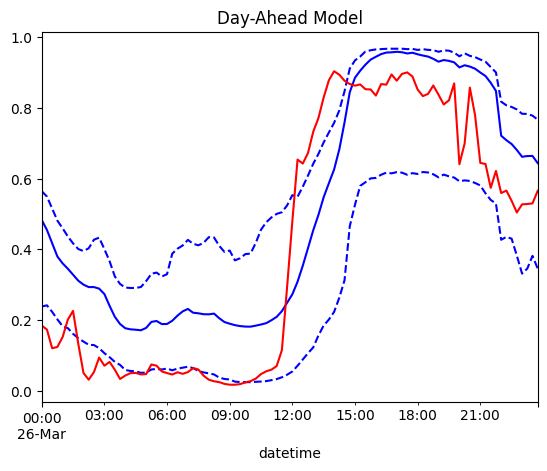

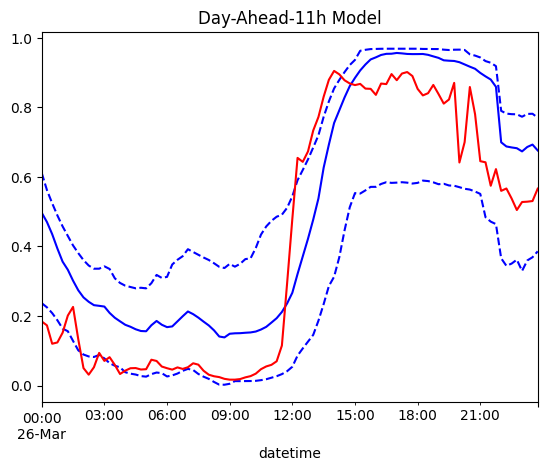

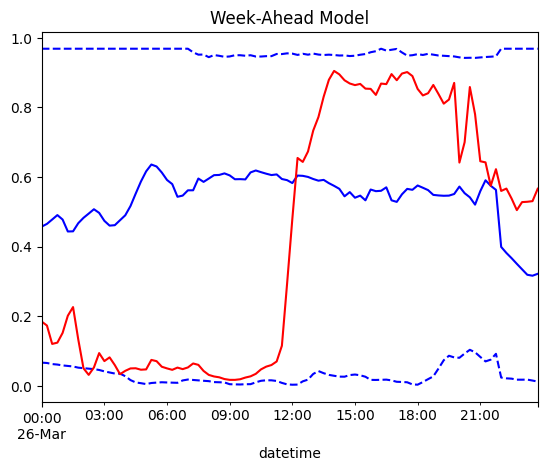

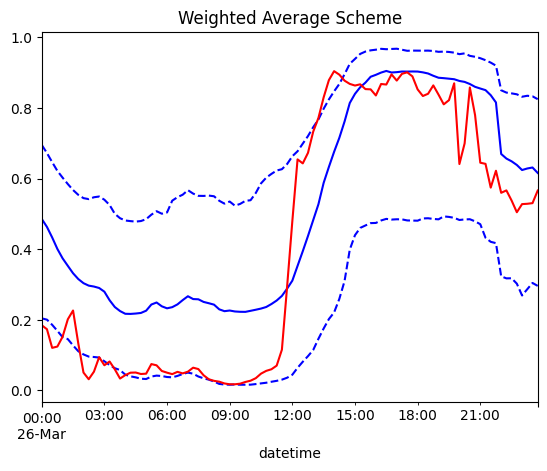

/Users/gio/Desktop/Elia-RES-Forecasting/source/plots/plot_forecasts.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_norm_diff.loc[:, 'ramp'] = (np.abs(wind_power_changes) > 0.3).astype(int)


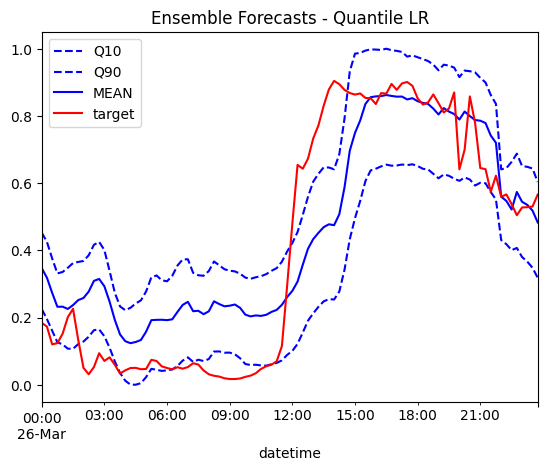

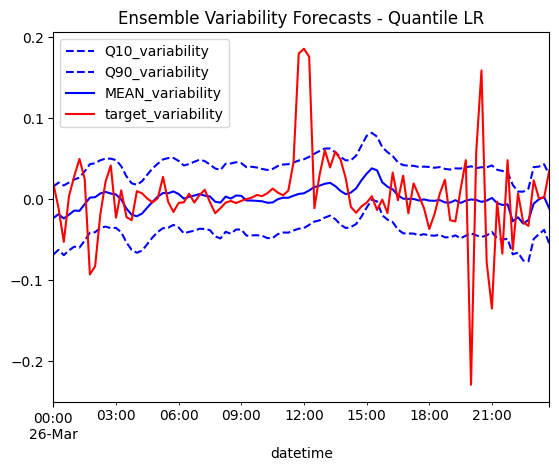

In [37]:
# ----------------- Display Results -----------------#
#
if ens_params['plot_baseline']:
    plot_baseline_forecasts(df_dayahead, model_name='Day-Ahead Model')
    plot_baseline_forecasts(df_dayahead11h, model_name='Day-Ahead-11h Model')
    plot_baseline_forecasts(df_weekahead, model_name='Week-Ahead Model')

# plot forecasts weighted avg
if ens_params['plot_weighted_avg']:
    plot_weighted_avg_forecasts(df_weighted_avg)

# plot forecasts ensemble
plot_ensemble_forecasts(df_pred_ensemble, df_test_ensemble)
nr_previous_days = len(pd.date_range(start=start_training_timestamp, end=end_training_timestamp, freq='1D')) - 1
plt.title(f'Ensemble Forecasts - Quantile {ens_params["model_type"]}')
plot_ramp_events(df_test_norm_diff, ens_params['compute_abs_difference'])
if not ens_params['zoom_in_variability']:  # zoom in the variability forecasts
    plt.ylim(-0.01, 1)
plt.show()

# plot variability forecast results
plot_var_ensemble_forecasts(df_var_ensemble, df_2stage_test)
nr_previous_days = len(pd.date_range(start=start_training_timestamp, end=end_training_timestamp, freq='1D')) - 1
plt.title(f'Ensemble Variability Forecasts - Quantile {ens_params["var_model_type"]}')
plot_ramp_events(df_test_norm_diff, ens_params['compute_abs_difference'])
if not ens_params['zoom_in_variability']:  # zoom in the variability forecasts
    plt.ylim(-0.6, 0.6)
plt.show()

# Forecasters Contribution Assessment

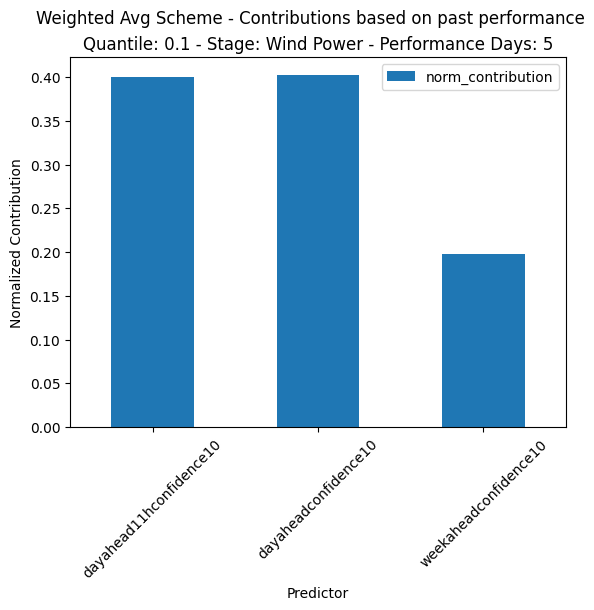

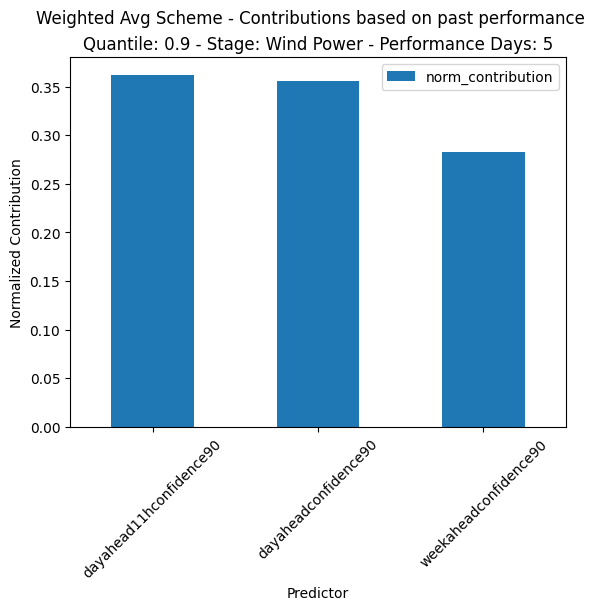

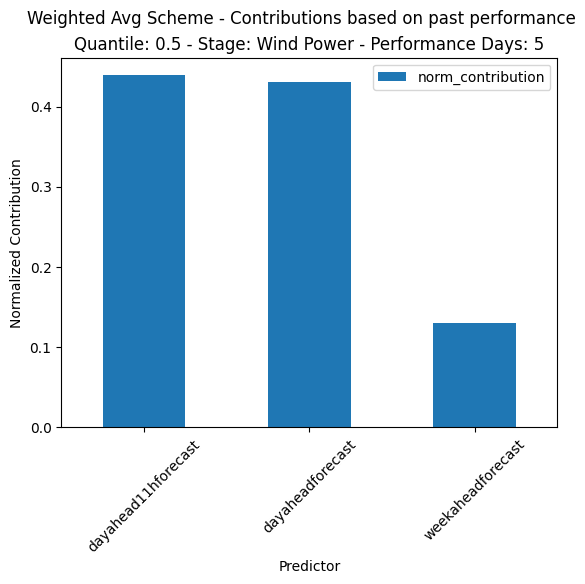

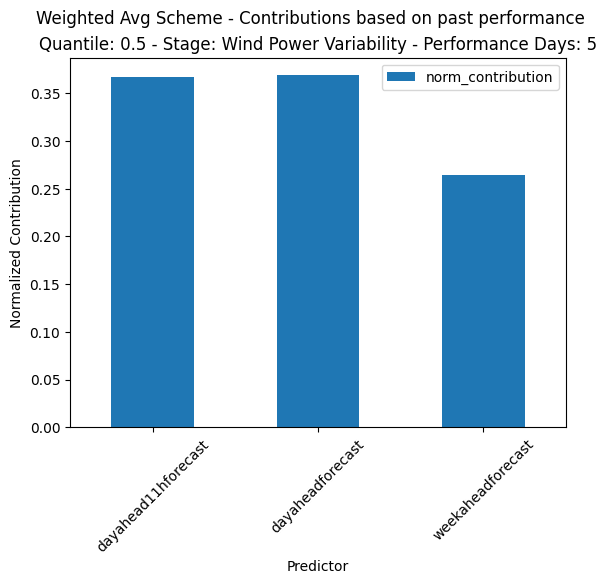

In [38]:
# plot contribution weighted average
if ens_params['plot_importance_weighted_avg']:
    for quantile in ens_params['quantiles']:
        plot_weight_avg_contributions(dict_weights, quantile, stage='Wind Power', days = weight_avg_params['window_size_valid'])

# plot contribution weighted average
if ens_params['plot_importance_weighted_avg']:
    plot_weight_avg_contributions(dict_weights_var, quantile=0.5, stage='Wind Power Variability', days= weight_avg_params['window_size_valid'])

2024-06-14 18:52:22.131 | INFO     | __main__:<module>:4 -    
2024-06-14 18:52:22.132 | INFO     | __main__:<module>:5 -  EX-Post Payments with loss-based importance 


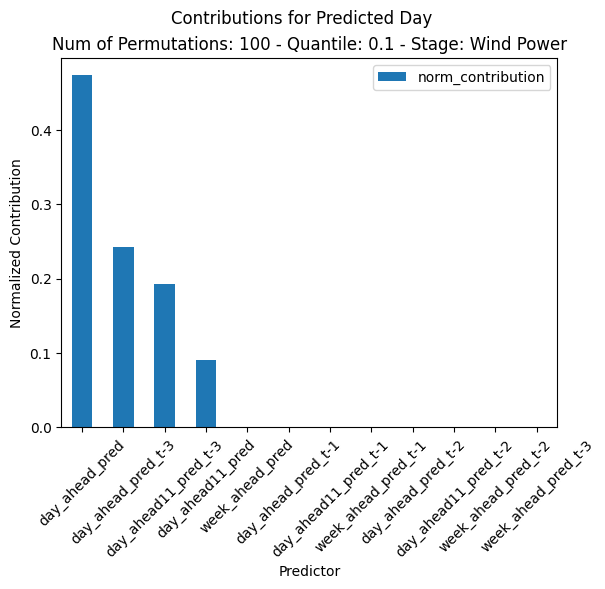

2024-06-14 18:52:23.305 | INFO     | __main__:<module>:13 -    
2024-06-14 18:52:23.310 | INFO     | __main__:<module>:4 -    
2024-06-14 18:52:23.313 | INFO     | __main__:<module>:5 -  EX-Post Payments with loss-based importance 


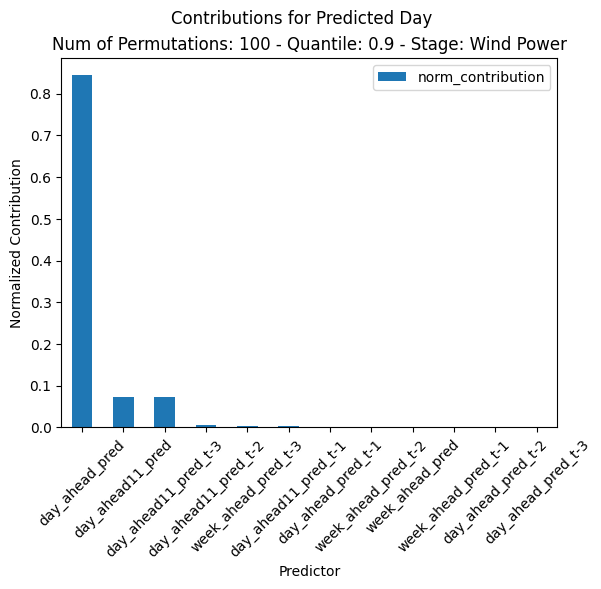

2024-06-14 18:52:23.697 | INFO     | __main__:<module>:13 -    
2024-06-14 18:52:23.697 | INFO     | __main__:<module>:4 -    
2024-06-14 18:52:23.698 | INFO     | __main__:<module>:5 -  EX-Post Payments with loss-based importance 


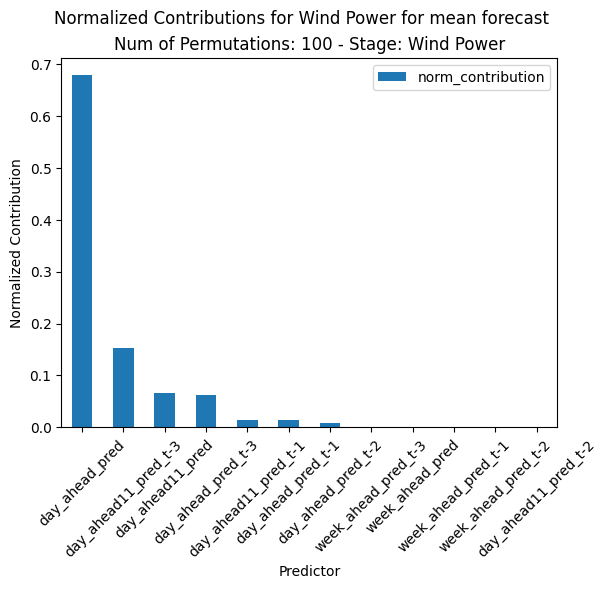

2024-06-14 18:52:23.951 | INFO     | __main__:<module>:13 -    


In [39]:
if ens_params['plot_importance_permutation_first_stage']:
    for quantile in ens_params['quantiles']:
            previous_day_results = previous_day_results_first_stage[quantile]
            logger.info('   ')
            logger.opt(colors=True).info(f'<fg 250,128,114> EX-Post Payments with loss-based importance </fg 250,128,114>')
            resultsdf = first_stage_permutation_importance(ens_params['nr_permutations'], 
                                                        quantile, 
                                                        previous_day_results['fitted_model'], 
                                                        previous_day_results['X_test_augmented'], 
                                                        y_test, 
                                                        previous_day_results['df_train_ensemble_augmented'])
            plot_normalized_contributions(ens_params['nr_permutations'], quantile, resultsdf, stage='Wind Power')
            logger.info('   ')

2024-06-14 18:52:23.958 | INFO     | __main__:<module>:4 -    
2024-06-14 18:52:23.959 | INFO     | __main__:<module>:5 -  EX-Post Payments with loss-based importance 


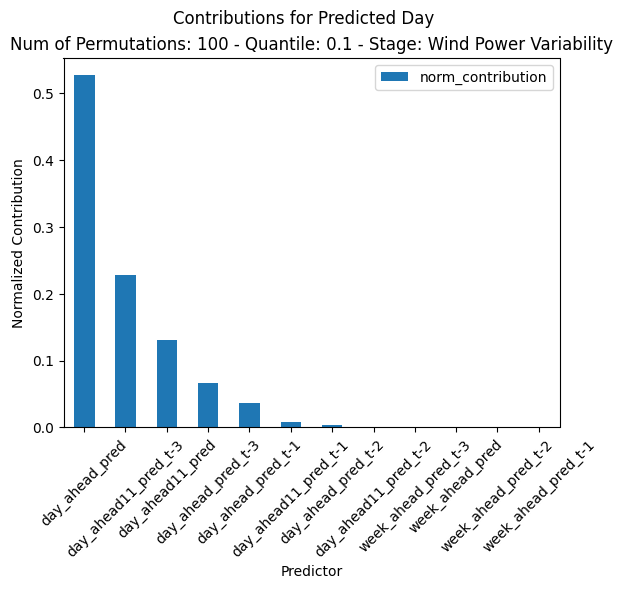

2024-06-14 18:52:25.773 | INFO     | __main__:<module>:4 -    
2024-06-14 18:52:25.775 | INFO     | __main__:<module>:5 -  EX-Post Payments with loss-based importance 


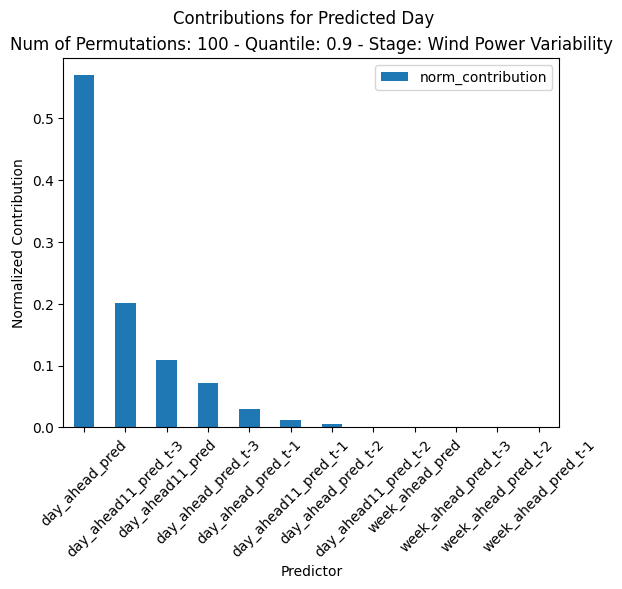

2024-06-14 18:52:26.715 | INFO     | __main__:<module>:4 -    
2024-06-14 18:52:26.716 | INFO     | __main__:<module>:5 -  EX-Post Payments with loss-based importance 


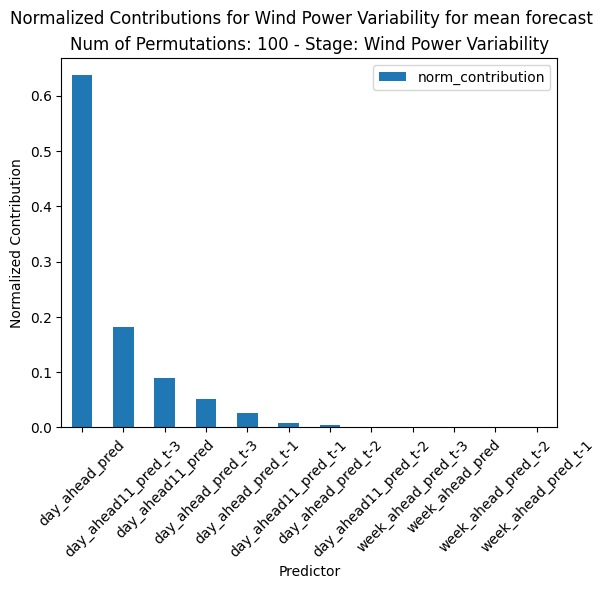

In [40]:
if ens_params['plot_importance_permutation_second_stage']:
    for quantile in ens_params['quantiles']:
        previous_day_results = previous_day_results_second_stage[quantile]
        logger.info('   ')
        logger.opt(colors=True).info(f'<fg 250,128,114> EX-Post Payments with loss-based importance </fg 250,128,114>')
        resultsdf = second_stage_permutation_importance(ens_params['nr_permutations'],
                                                        quantile, 
                                                        previous_day_results['var_fitted_model'], 
                                                        previous_day_results['fitted_model'], 
                                                        previous_day_results['X_test_augmented'], 
                                                        y_test, 
                                                        previous_day_results['df_train_ensemble_augmented'],
                                                        previous_day_results['X_train_augmented'], 
                                                        previous_day_results['df_train_ensemble'], 
                                                        previous_day_results['df_test_ensemble'], 
                                                        y_train, 
                                                        ens_params['order_diff'], 
                                                        ens_params['max_lags_var'], 
                                                        ens_params['augment_var'], 
                                                        start_prediction_timestamp)
        plot_normalized_contributions(ens_params['nr_permutations'], 
                                    quantile, resultsdf, stage='Wind Power Variability')

# Display Performance metrics

In [41]:
if sim_params['display_metrics']:
    display_forecasting_metrics(ens_params=ens_params, 
                                rmse_ensemble=rmse_ensemble, rmse_weighted_avg=rmse_weighted_avg, rmse_equal_weights=rmse_equal_weights,
                                rmse_dayahead=rmse_dayahead, rmse_dayahead_11h=rmse_dayahead_11h, rmse_week_ahead=rmse_week_ahead,
                                pinball_ensemble_q10=pinball_ensemble_q10, pinball_weighted_avg_q10=pinball_weighted_avg_q10, pinball_equal_weights_q10=pinball_equal_weights_q10,
                                pinball_dayahead_q10=pinball_dayahead_q10, pinball_dayahead_11h_q10=pinball_dayahead_11h_q10, pinball_week_ahead_q10=pinball_week_ahead_q10,
                                pinball_ensemble_q90=pinball_ensemble_q90, pinball_weighted_avg_q90=pinball_weighted_avg_q90, pinball_equal_weights_q90=pinball_equal_weights_q90,
                                pinball_dayahead_q90=pinball_dayahead_q90, pinball_dayahead_11h_q90=pinball_dayahead_11h_q90, pinball_week_ahead_q90=pinball_week_ahead_q90,
                                rmse_var_ensemble=rmse_var_ensemble, rmse_var_weighted_avg=rmse_var_weighted_avg, rmse_var_equal_weights=rmse_var_equal_weights,
                                rmse_var_dayahead=rmse_var_dayahead, rmse_var_dayahead_11h=rmse_var_dayahead_11h, rmse_var_week_ahead=rmse_var_week_ahead)

2024-06-14 18:52:27.863 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 18:52:27.873 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 18:52:27.873 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 18:52:27.874 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.167
2024-06-14 18:52:27.874 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.175
2024-06-14 18:52:27.874 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.208
2024-06-14 18:52:27.875 | INFO     | source.ensemble.s